# 5. Support vector machines

In [0]:
%matplotlib inline
import warnings;
warnings.filterwarnings('ignore');
import matplotlib.pyplot as plt;
import numpy as np;
import pandas as pd;
import seaborn as sns;
sns.set_context("notebook", font_scale=1.4);
sns.set_style("whitegrid");

In [0]:
###util methods
def plot_logistic(theta):
	f = lambda x, theta: 1. / (1. + np.exp(-x.dot(theta)))
	#create a dataset with m=2
	x = np.c_[np.ones(100), np.linspace(-10,20,100)] #x0 is set 1
	#compute f(x,theta)
	y = f(x, theta)
	plt.xlabel(r"$\theta^{\prime} x$", fontsize=20)
	plt.ylabel(r"$lr(x,\theta)$", fontsize=20)
	plt.plot(x.dot(theta), y)
def plot_lr_cost2():
	a = np.arange(-6, 6, .001)
	plt.figure(figsize=(8,4))
	plt.plot(a,-1*np.log(1/(1+(np.exp(-1*a)))),linewidth=3.0,label="y=1")
	plt.plot(a,-1*np.log(1-(1/(1+(np.exp(-1*a))))),linewidth=3.0,label="y=0")
	plt.xlabel(r"$lr(x,\theta)$", fontsize=22)
	plt.ylabel(r"$J(lr(x,\theta))$", fontsize=20)
	plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
def plot_svm_cost():
	a = np.arange(-6, 6, .001)
	k1 = lambda x: np.maximum(0, 1 - x)
	k0 = lambda x: np.maximum(0, 1 + x)
	plt.figure(figsize=(8,4))
	plt.plot(a,-1*np.log(1/(1+(np.exp(-1*a)))),linewidth=2.0, color='0.8',label="")
	plt.plot(a,-1*np.log(1-(1/(1+(np.exp(-1*a))))),linewidth=2.0, color='0.8', label="")
	plt.plot(a,k1(a),linewidth=3.0,label="y=1")
	plt.plot(a,k0(a),linewidth=3.0,label="y=0")
	plt.xlabel(r"$f(x,\theta)$", fontsize=22)
	plt.ylabel(r"$J(f(x,\theta))$", fontsize=20)
	plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
def plot_svm_decision_function(clf):
	"""Plot the decision function for a 2D SVC"""
	x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
	y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
	Y, X = np.meshgrid(y, x)
	P = np.zeros_like(X)
	for i, xi in enumerate(x):
		for j, yj in enumerate(y):
			P[i, j] = clf.decision_function(np.array([xi, yj]).reshape(1,-1))
	return plt.contour(X, Y, P, colors='k',
					   levels=[-1, 0, 1],
					   linestyles=['--', '-', '--'])

We discussed the regularized logistic regression algorithm to build logistic models for solving classification tasks. Here we will discuss another very popular **linear classification model** called the **support vector machine** (SVM). As with logistic regression the SVM can be applied only on linearly separable **two class** data sets. 

So how is the SVM model different form the logistic regression model? As we will see there are some mathematical differences into how the SVM computes the linear decision boundary that allows for an intuitive regularization of the model. In addition, as we will see the formulation of the linear SVM facilitates an efficient transformation of the linear to a non-linear decision boundarie through the application of what is know as a **kernel function**. 

The SVM algorithm is known to prevent overfitting very well and is therefor applied very successfully to for instance high-dimensional data sets (data sets with many features, many of which redundant or irrelevant) with relatively low number of data points such as genome annotation (prediction of promotor regions, coding regions, splice sites, start of translation, etc.), gene expression (e.g. classifying control from diseased patients), and protein function prediction data sets.

As we will see the formulation of the SVM allows for a direct calculation of a **separating hyperplane** (the decision boundary) that is **regulated** by forcing a **maximal margin between the classes**. 

The model that is fitted is again a linear function, just as with linear regression:

$$f(x,\theta)=\theta_0x_0 + \theta_1x_1 + \theta_2x_2+...+\theta_mx_m = \theta^{\prime} x.$$

A threshold is used to map $f(x,\theta)$ onto a class. However, as we deal with classification tasks we assume the data is linearly separable and not linearly related, so again we need a cost function that implements this notion. To explain how the SVM works we start from the logistic regression model and explain how the SVM cost function is very similar to the logistic regression cost function. 

For convenience we will write the logistic model as $lr(x,\theta)$:

$$lr(x,\theta) = \frac{1}{1+\exp(-\theta^{\prime} x)}.$$

Notice that when our response is $y=1$, we want $\theta^{\prime} x$ to be a very large, positive value so that $lr(x,\theta) \rightarrow 1$, and when $y=0$, we want $\theta^{\prime} x$ to be a very large, negative value, so that $lr(x,\theta) \rightarrow 0$. We can plot this as follows for $\theta=(2,-0.5)$:

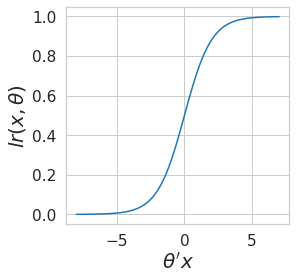

In [28]:
plt.figure(figsize=(4,4))
plot_logistic([2, -0.5])
plt.show()

The cost function for the logistic regression model was as follows:

$$J(\theta)=-[\frac{1}{n}\sum\limits_{i=1}^ny^{(i)}log(lr(x^{(i)},\theta))+(1-y^{(i)})log(1- lr(x^{(i)},\theta))]+\frac{\lambda}{2m}\sum\limits_{j=1}^{m}\theta_j^2,$$

We had seen that if $y^{(i)}=1$ then the cost function $J(\theta)$ is incremented by

$$-log(lr(x^{(i)},\theta))$$

and if $y^{(i)}=0$ then the cost function $J(\theta)$ is incremented by

$$-log(1- lr(x^{(i)},\theta)).$$

We plotted the prediction $lr(x,\theta)$ against these increments:

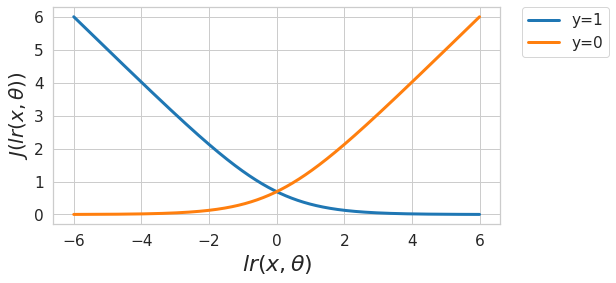

In [29]:
plot_lr_cost2()
plt.show()

We saw that for for $y=1$ if $lr(x,\theta)$ is large then the blue curve shows that the increment to the cost function is low, while if $lr(x,\theta)$ is small then the increment is large. Similarly for $y=0$ if $lr(x,\theta)$ is large then the green curve shows that the increment to the cost is large as well, while if $lr(x,\theta)$ is small then the increment is also small.

So far we have seen nothing new. Now, the cost function of the SVM also consists of two terms $k_0$ and $k_1$ that will contribute to the cost depending on the value of $y$. Similar to logistic regression, if $y=1$ then the contribution to the cost function of the SVM becomes

$$k_1(\theta^{\prime} x)=max(0,1-\theta^{\prime} x),$$

which follows the blue line in the plot below. If $y=0$ then the contribution to the cost function of the SVM becomes

$$k_0(\theta^{\prime} x)=max(0,1+\theta^{\prime} x),$$

which follows the green line in the plot below:

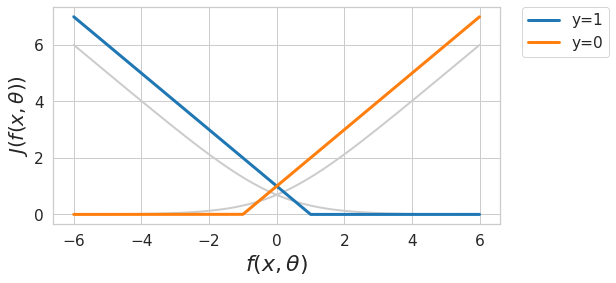

In [30]:
plot_svm_cost()
plt.show()

Notice how similar this cost function is as compared to the cost function of logistic regression (shown in grey). The difference is that it consists of linear approximations (know as a **piecewise linear function**) of the smooth logistic regression cost.

The cost function $J(\theta)$ for the SVM then becomes

$$J(\theta) = \left[ C \sum_{i=1}^n y^{(i)} k_1(\theta^{\prime} x^{(i)}) + (1-y^{(i)}) k_0(\theta^{\prime} x^{(i)}) \right] + \frac{1}{2}\sum_{j=1}^m \theta^2_j,$$

where the hyperparameter $C$ plays a role equivalent to the regularization parameter $\lambda$ in regularized logistic regression ($C=1/\lambda$). 

Notice that to make $k_1$ small when $y=1$, we want $f(x,\theta) \ge 1$ rather than just being greater than zero. Similarly, to make $k_0$ small when $y=0$, we want $f(x,\theta) \le -1$ rather than just being less than zero. Now what does this mean? If we set $C$ very large, we would want the summation term (between the square brackets) to be equal or close to zero in order to minimize the cost function $J(\theta)$. Let's assume we have a data set that is **perfectly linearly separable** so we can make the summation term zero. The SVM cost function then essentially becomes:

$$\min_{\theta} \frac{1}{2} \sum_{j=1}^m \theta^2_j$$
$$\begin{aligned}
\text{subject to }\theta^{\prime} x^{(i)} \ge 1 &\text{ if } y^{(i)}=1\\
\theta^{\prime} x^{(i)} \le -1 &\text{ if } y^{(i)}=0                   
\end{aligned}$$

The constraints of the cost function can be satisfied because we assumed the data set is perfectly linearly separable.

Consider this dataset with two linearly separable classes:

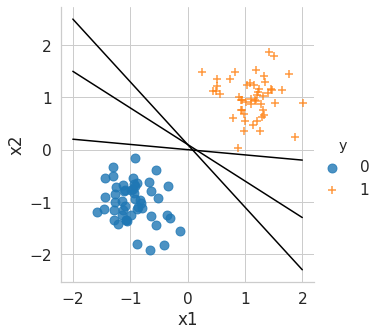

In [31]:
from sklearn.datasets.samples_generator import make_blobs

dataset_blobs = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554/master/notebooks/5_SVM/dataset_blobs.csv")

#plt.figure(figsize=(4,4))
sns.lmplot(x="x1", y="x2", data=dataset_blobs, hue='y', markers=['o','+'], 
           fit_reg=False, height=5, scatter_kws={"s": 80})
x = np.linspace(-2, 2, 30)
plt.plot(x,-1.2*x+0.1,c='k')
plt.plot(x,-0.7*x+0.1,c='k')
plt.plot(x,-0.1*x,c='k')
plt.show()

We can see that there are many decision boundaries that separate the two classes perfectly. However, the (unique) decision boundary computed by the SVM (black line) looks like this:

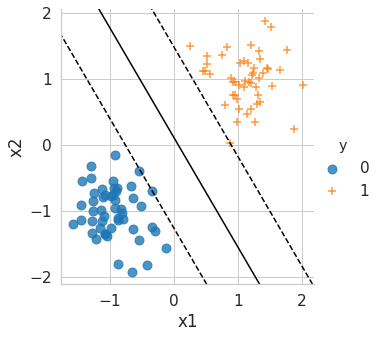

In [32]:
from sklearn.svm import SVC

X = dataset_blobs.copy()
y = X.pop('y')

clf = SVC(kernel='linear')
clf.fit(X, y)

sns.lmplot(x="x1", y="x2", data=dataset_blobs, hue='y', markers=['o','+'],
           fit_reg=False, height=5, scatter_kws={"s": 80})
plot_svm_decision_function(clf)
plt.show()

Let's consider all points $\theta^{\prime} x^{(i)} = 1$. All these points lay on the upper dashed line. Similarly all points $\theta^{\prime} x^{(i)} = -1$ lay on the lower dashed line. This means that all the green data points satisfy  $\theta^{\prime} x^{(i)} \ge 1$ and all the blue points satisfy $\theta^{\prime} x^{(i)} \le -1$, which means the contribution to the cost for all data points is zero, as expected. The distance between the two dashed lines is

$$\frac{2}{\sqrt{\sum_{j=1}^m \theta^2_j}},$$


and is called the **margin** between the two classes. This means that minimizing 

$$\min_{\theta} \frac{1}{2} \sum_{j=1}^m \theta^2_j,$$

is the same as maximizing the margin between the classes. 

If there exists no vector $\theta$ for which 

$$\begin{aligned}
\theta^{\prime} x^{(i)} \ge 1 &\text{ if } y^{(i)}=1 &\text{and}\\
\theta^{\prime} x^{(i)} \le -1 &\text{ if } y^{(i)}=0,
\end{aligned}$$

then all points that do not satisfy the constraints will contribute to the cost. For data points with $y=1$ (green points) that end up below the upper dashed line the contribution to the cost **increases linearly** with the distance to this dashed line ($k_1(\theta^{\prime} x)$). For data points with $y=0$ (blue points) that end up above the lower dashed line the contribution to the cost also increases linearly with the distance to this lower dashed line ($k_0(\theta^{\prime} x)$). 

In the plot below we see two data points that will contribute to the cost, the misclassified green point will contribute more to the cost than the misclassified blue point.

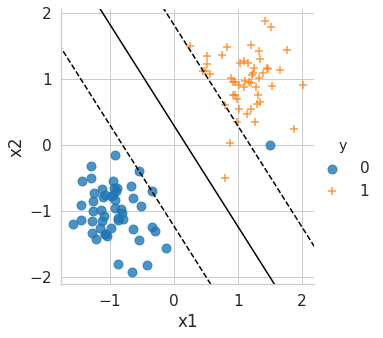

In [33]:
tmp = pd.DataFrame([[1.5,0],[0.8,-0.5]],columns=['x1','x2'])
tmp['y'] = [0,1]

dataset_blobs = dataset_blobs.append(tmp)

X = dataset_blobs.copy()
y = X.pop('y')

clf = SVC(kernel='linear')
clf.fit(X, y)

sns.lmplot(x="x1", y="x2", data=dataset_blobs, hue='y', markers=['o','+'], 
           fit_reg=False, height=5, scatter_kws={"s": 80})
plot_svm_decision_function(clf)
plt.show()

We can see that in this case the SVM needs to balance the number of data points that contribute to the cost and the size of the margin. The user can control this balance using hyperparameter $C$. The higher the value for $C$ the higher the contribution of the misclassified data points to the cost will be. The lower the value $C$ the larger the margin will be.

Next we will briefly look at how the SVM formulation for linear separating hyperplanes can be exended to non-linear separations efficiently using what is known a the **kernel-trick**. As with logistic regression we can expand the data set with polynomial transformations of the features to allow for a non-linear (polynomial) decision boundary. Let's take a closer look at what exactly happens to the data when we add these transformations. 

Consider the following 1-dimensional two class data set: 

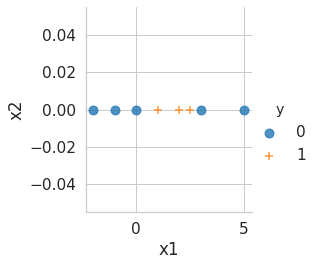

In [34]:
dataset_example = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554/master/notebooks/5_SVM/dataset_example.csv")    
    
sns.lmplot(x="x1", y="x2", data=dataset_example, hue='y', markers=['o','+'], 
           fit_reg=False, height=4, scatter_kws={"s": 80})
plt.show()

Clearly, it is impossible to draw a straight line anywhere that will separate the two classes. However, if we add a polynomial feature of degree 2, the classes become linearly separable:

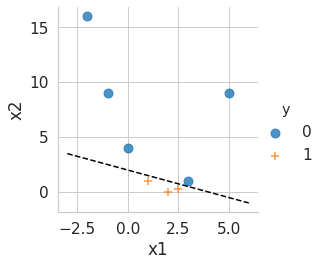

In [35]:
dataset_example['x2'] = (dataset_example['x1'] - 2) ** 2
sns.lmplot(x="x1", y="x2", data=dataset_example, hue='y', markers=['o','+'], 
           fit_reg=False, height=4, scatter_kws={"s": 80})
xvals = np.linspace(-3, 6)
plt.plot(xvals, 2 - 0.5*xvals, 'k--')
plt.show()

The problem is that this approach is not very efficient. If we would use scikit-learn to compute polynomial features of degree 3 for a data set with 100 features we would get 187.460 features. For 150 features this would be 608.685 features. Clearly we can't use the polynomial features trick for data sets with many features. 

An alternative is to employ a function that **measures the similarity between two points in an augmented feature space** (such as the polynomial feature space) **without having to transform the feature vectors**. These functions that define the similarity between two data points $x^{(i)}$ and $x^{(j)}$ are called **kernels** $K(x^{(i)},x^{(j)})$. You can think of them as dot products between $x^{(i)}$ and $x^{(j)}$ in the augmented feature space without having to explicitly calculate all the augmented feature values. 

The model for the SVM with kernel $K(x^{(i)},x^{(j)})$ is written as 

$$f(x,\theta)=\sum_{i=1}^{n} \theta_i K(x,x^{(i)})+\theta_0.$$

Now this is tricky as it is very different from our previous models. In the kernel SVM formulation the model parameters $\theta$ are **weights for the data points, not for the features**. A nice property of SVMs is that many of these weights $\theta_i$ will become zero for the optimal fit, i.e. these training points are not required to fit the model. The training points $x^{(i)}$ with $\theta_i \gt 0$ are called the **support vectors**. A well known kernel function is the polynomial kernel of degree $d$

$$K(x^{(i)},x^{(j)})=(x^{(i)} \cdot x^{(j)} + c)^d,$$

with $c$ again a hyperparameter. 

Training an SVM with a polynomial kernel of degree 2 is the same as training a linear SVM on a data set augmented with polynomial features of degree 2. Let's see if this is indeed the case. We create a data set that is not linearly separable and augment it with polynomial features of degree 2. When we fit a linear SVM on this augmented data we can see that the decision boundary nicely separates the classes:

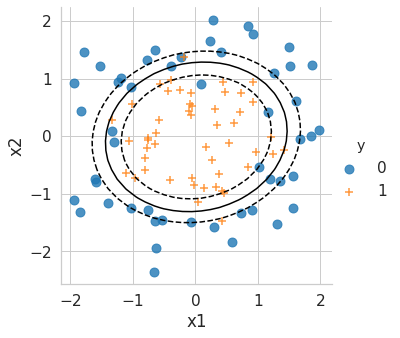

In [36]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

dataset1 = pd.read_csv('https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554/master/notebooks/5_SVM/svm_example1.csv')
X = dataset1.copy()
y = X.pop('y')

clf = SVC(kernel='linear',C=1)
polynomial_features = PolynomialFeatures(degree=2)
model = Pipeline([("polynomial_features", polynomial_features),
                         ("SVC", clf)])
model.fit(X,y)

sns.lmplot(x="x1", y="x2", data=dataset1, hue='y', markers=['o','+'], 
           fit_reg=False, height=5, scatter_kws={"s": 80})
plot_svm_decision_function(model)
plt.show()

Now we train an SVM with polynomial kernel with degree 2 on the original data set:

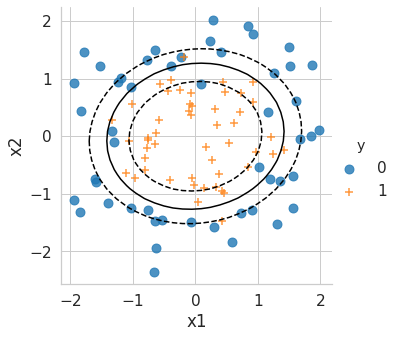

In [37]:
model = SVC(kernel='poly',C=1,degree=2)
model.fit(X,y)

sns.lmplot(x="x1", y="x2", data=dataset1, hue='y', markers=['o','+'], 
           fit_reg=False, height=5, scatter_kws={"s": 80})
plot_svm_decision_function(model)
plt.show()

We find that this is indeed the exact same decision boundary. But in this case we did not have to augment the data set to compute a non-linear decision function! 

Another very common kernel is the Gaussian:

$$K(x^{(i)}, x^{(j)}) = \exp\left[-\frac{||x^{(i)}-x^{(j)}||^2}{2 \sigma^2}\right].$$

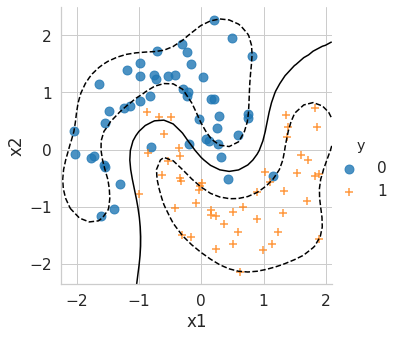

In [38]:
dataset2 = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554/master/notebooks/5_SVM/svm_example2.csv")
X = dataset2.copy()
y = X.pop('y')

model = SVC(kernel='rbf',C=1,gamma=1)
model.fit(X,y)

sns.lmplot(x="x1", y="x2", data=dataset2, hue='y', markers=['o','+'], 
           fit_reg=False, height=5, scatter_kws={"s": 80})
plot_svm_decision_function(model)
plt.show()

When the train data is not perfectly separable then there remains a choice to be made for the value of the SVM hyperparameter $C$. In a SVM, regularization results in a **soft margin** that allows some points to cross the optimal decision boundary. We can think of $C$ as a "budget" for permitting points to exceed the margin.

Let's see what happens if we decrease $C$ on an artificial data set that is not linearly separable. We will fit an SVM model with $C=100$ (i.e. more weight on the errors, which results in a smaller margin):

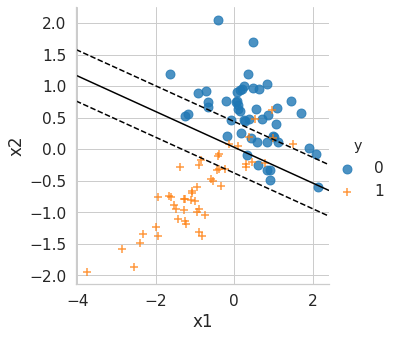

In [39]:
dataset3 = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554/master/notebooks/5_SVM/svm_example3.csv")

X = dataset3.copy()
y = X.pop('y')

sns.lmplot(x="x1", y="x2", data=dataset3, hue='y', markers=['o','+'], 
           fit_reg=False, height=5, scatter_kws={"s": 80})
model = SVC(kernel='linear',C=100)
model.fit(X,y)
plot_svm_decision_function(model)
plt.show()

If we set $C=0.01$ we enforce a larger margin:

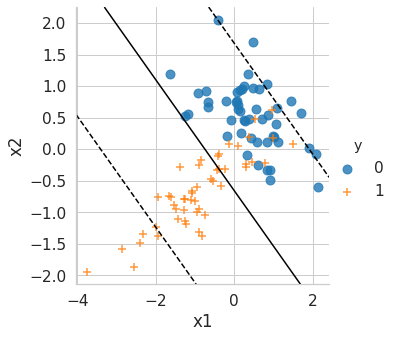

In [40]:
sns.lmplot(x="x1", y="x2", data=dataset3, hue='y', markers=['o','+'], 
           fit_reg=False, height=5, scatter_kws={"s": 80})
model = SVC(kernel='linear',C=0.01)
model.fit(X,y)
plot_svm_decision_function(model)
plt.show()

In this case the decision boundary has significantly changed. The question is which value for $C$ is best? This is the value that results in the best generalization performance for unseen external data. We can use cross-validation to estimate this. We use `GridSearchCV` in scikit-learn to find the optimal value for $C$: 

In [41]:
from sklearn.model_selection import GridSearchCV

search_space = np.logspace(-10, 14, 10, base=2)

params = dict(C=search_space)
grid_search = GridSearchCV(model, param_grid=params, iid=False)

grid_search.fit(X, y)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']

for mean_score, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("{:.3f} (+/-{:.3f}) for {}".format(mean_score, std * 2, params))

0.790 (+/-0.117) for {'C': 0.0009765625}
0.790 (+/-0.117) for {'C': 0.006200785359250777}
0.870 (+/-0.120) for {'C': 0.03937253280921478}
0.890 (+/-0.117) for {'C': 0.25}
0.870 (+/-0.136) for {'C': 1.587401051968199}
0.870 (+/-0.136) for {'C': 10.079368399158977}
0.870 (+/-0.136) for {'C': 64.0}
0.870 (+/-0.136) for {'C': 406.3746693038584}
0.870 (+/-0.136) for {'C': 2580.318310184698}
0.870 (+/-0.136) for {'C': 16384.0}
